In the interest of eventually helping to design the CE OMC, I think I should begin by understanding the aLIGO OMC, and the design choices that went into it. I also believe this will help me get back in the groove of using FINESSE. All around good.

In [1]:
import finesse
import finesse.components as fc
import finesse.detectors as fd
import finesse.solutions as fs
import finesse.analysis as fa
import numpy as np
import matplotlib.pyplot as plt
from aligo_omc import omc_builder

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#000E54','#F76900','#FF8E00'])
rc('font', **{'family': 'monospace'})
plt.style.use("dark_background")

# Index: 
* [Relevant Background](#zeroth-bullet)
* [Definition of Cavity Model](#first-bullet)
    * [Realistic Model](#first-sub-bullet)
    * [Equivalent Linear Model](#second-sub-bullet)
* [Beam Tracing/Propagation](#second-bullet)
* [Analysis](#third-bullet)

## Relevant Background <a class="anchor" id="zeroth-bullet"></a>

The aLIGO OMC is a small ($\approx$ 1m) cavity located at the AS port of the interferometer just before the DC readout photodiodes. It's primary function is to filter out carrier HOMs and RF frequency sidebands which contribute shot noise to the readout signal.

A schematic diagram of the aLIGO OMC as it appears on the optical bench is shown below:

![OMC_Layout](omc_diagram.JPG)

Here is a diagram of the OMC as-built (LIGO-D1300507-v1):

![OMC_Diagram](L1OMC_asbuilt-1.png)

## Definition of Cavity Model <a class="anchor" id="first-bullet"></a>

### Realistic Model <a class="anchor" id="zeroth-sub-bullet"></a>

This model was constructed referencing the "as-built" diagram shown directly above for the lengths and LIGO-T1000276-v5 for optical parameters..

In [2]:
omc = finesse.Model() #define model
omc.modes(maxtem=8) #set HOM content, in this case the max TEM: n+m = 3
print("Higher Order Modes used: ", omc.homs) #to verify


### Vars ###
highref_T = omc.add_parameter("highref_T", 48/1e6, changeable_during_simulation = True) #50ppm (measured transmission of high-refl, see LIGO-T1000276-v5)
inout_T = omc.add_parameter("inout_T", 7930/1e6, changeable_during_simulation = True) #8300ppm (measured T of in/out couplers)
aoi = omc.add_parameter("aoi", 4, units = "deg", changeable_during_simulation = True) #angle of incidence in degrees
roc = omc.add_parameter("mirror_roc", 2.575, units = "m", changeable_during_simulation = True) #measured RoC of high-reflectors LIGO-T1000276-v5

### Input Beam ###
laser = omc.add(fc.Laser("Input", P=1)) #1W input laser power
laser.tem(n=1,m=0,factor=1) #Forcing power into HOMs)
laser.tem(n=0,m=1,factor=1)
laser.tem(n=1,m=1,factor=1)
laser.tem(n=0,m=2,factor=1)
laser.tem(n=2,m=0,factor=1)


### Mirrors ###

#Input/Output Couplers
m1 = omc.add(fc.Beamsplitter("M1", R = 1-inout_T, T = inout_T, alpha=aoi)) #high reflectance, "thin" mirror
m2 = omc.add(fc.Beamsplitter("M2", R = 1-inout_T, T = inout_T, alpha=aoi)) 

#High-Reflectors 
m3 = omc.add(fc.Beamsplitter("M3", R = 1-highref_T, T = highref_T, Rc=roc.ref, alpha=aoi))
m4 = omc.add(fc.Beamsplitter("M4", R = 1-highref_T, T = highref_T, Rc=roc.ref, alpha=aoi))

### Spaces ###
s1 = omc.add(fc.Space("s1", portA=laser.p1, portB=m1.p1,L=1)) #laser -> 1m -> m1 (length here makes no real difference)
s2 = omc.add(fc.Space("s2", portA=m1.p3, portB=m2.p1,L=0.2815)) #m1 -> 0.2815m -> m2 #Lengths: LIGO-D1300507
s3 = omc.add(fc.Space("s3", portA=m2.p2, portB=m3.p1,L=0.2842)) #m2 -> 0.2842m -> m3
s4 = omc.add(fc.Space("s4", portA=m3.p2, portB=m4.p1,L=0.2815)) #m3 -> 0.2815m -> m4
s5 = omc.add(fc.Space("s5", portA=m4.p2, portB=m1.p4,L=0.2842)) #m4 -> 0.2842m -> m1
                                                                
### Cavity ###
omc.add(fc.Cavity("OMC",m1.p3.o,m3.p1.i)) 

###Beam Parameter###
#Definition of a BP here is unnecessary, FINESSE performs a beam trace when analysis is run and uses whatever the cavity BP is.
#bp = omc.add(fc.Gauss("BeamParam",m1.fr1.i,z=190e-3,w0=496.1e-6)) #Defining input beam parameter for mode-matching

### Output PDs ###
#pd1 = omc.add(fd.PowerDetector("Trans",m2.p3.o)) #Photodiode on the back of output coupler.
#pd2 = omc.add(fd.PowerDetector("Refl",m1.p2.o)) #Photodiode on the front of input coupler

#ad1 = omc.add(fd.AmplitudeDetector("Fundamental_trans",m2.p3.o,f=0,n=0, m=0)) #amplitude detectors for HOMs (transmission)
#ad2 = omc.add(fd.AmplitudeDetector("OneZero_trans",m2.p3.o,f=0,n=1, m=0))
#ad3 = omc.add(fd.AmplitudeDetector("ZeroOne",m2.p3.o,f=0,n=0, m=1))


#ad1_1 = omc.add(fd.AmplitudeDetector("Fundamental_refl",m1.p2.o,f=0,n=0, m=0)) #amplitude detectors for HOMs (reflection)
#ad2_1 = omc.add(fd.AmplitudeDetector("OneZero_refl",m1.p2.o,f=0,n=1, m=0))
#ad3_1 = omc.add(fd.AmplitudeDetector("OneOne_refl",m1.p2.o,f=0,n=1, m=1))

#ad4 = omc.add(fd.AmplitudeDetector("OneOne_trans",m2.p3.o,f=0,n=1, m=1)) #(transmission)
#ad5 = omc.add(fd.AmplitudeDetector("TwoZero",m2.p3.o,f=0,n=2, m=0))
#ad6 = omc.add(fd.AmplitudeDetector("ZeroTwo",m2.p3.o,f=0,n=0, m=2))

cavp1 = omc.add(fd.CavityPropertyDetector("CavTMS", omc.OMC, "modesep")) #cavity property detectors
cavp2 = omc.add(fd.CavityPropertyDetector("CavLen", omc.OMC, "length"))

Higher Order Modes used:  [[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]
 [4 0]
 [3 1]
 [2 2]
 [1 3]
 [0 4]
 [5 0]
 [4 1]
 [3 2]
 [2 3]
 [1 4]
 [0 5]
 [6 0]
 [5 1]
 [4 2]
 [3 3]
 [2 4]
 [1 5]
 [0 6]
 [7 0]
 [6 1]
 [5 2]
 [4 3]
 [3 4]
 [2 5]
 [1 6]
 [0 7]
 [8 0]
 [7 1]
 [6 2]
 [5 3]
 [4 4]
 [3 5]
 [2 6]
 [1 7]
 [0 8]]


In [3]:
print(omc.OMC.draw()) #Cavity port couplings

o M1.p3.o
╰──o M2.p1.i
   ╰──o M2.p2.o
      ╰──o M3.p1.i
         ╰──o M3.p2.o
            ╰──o M4.p1.i
               ╰──o M4.p2.o
                  ╰──o M1.p4.i


In [4]:
print(f"Cavity Finesse: {omc.OMC.finesse}")
print(f"Cavity FSR: {omc.OMC.FSR/1e6} MHz") 
print(f"Cavity TMS (x): {omc.OMC.mode_separation[0]/1e6} MHz") 
print(f"Cavity Length: {omc.OMC.round_trip_optical_length} m") 
print(f"Cavity g-factor ([x,y]): {omc.OMC.g}")
print(f"Cavity RT Gouy ([x,y]): {omc.OMC.gouy}")

Cavity Finesse: 392.2268291698549
Cavity FSR: 264.97477284779916 MHz
Cavity TMS (x): 58.11265749934888 MHz
Cavity Length: 1.1314 m
Cavity g-factor ([x,y]): [0.59580697 0.59759819]
Cavity RT Gouy ([x,y]): [78.95301305 78.74380472]


### Equivalent Linear Symmetric Model <a class="anchor" id="second-sub-bullet"></a>

Following the technical note LIGO-T1000276-4, we can build an equivalent linear symmetric (LS) cavity which mimics the behavior of the bowtie OMC, but significantly simplifies the mathematics and analysis.

 In the case of a linear cavity (length $L$, mirror RoC $R$ and mirror power transmission $T$), we have the following exact expressions for various cavity parameters:
* $g$-factor: $1-L/R$
* FSR: $c/2L$
* Finesse: $\approx \pi/T$

Using the measured OMC parameters ($F = 390$, FSR $= 264.8$ MHz, $g$ $\approx$ 0.772), we see the power transmission must be:
\begin{equation}
T \approx \frac{\pi}{390} \approx 0.0081.
\end{equation}
Likewise, the length is:
\begin{equation}
L = \frac{c}{2(264.8 \textrm{MHz})} \approx 0.566 \textrm{m}
\end{equation}
And finally, the RoC is:
\begin{equation}
R = \frac{L}{1-g} = \frac{0.566 \textrm{m}}{1-0.772} \approx 2.482 \textrm{m}
\end{equation}

There is a minor caveat to doing it this way. Due to the asymmetry of the bowtie design (two flat mirrors, two curved mirrors) there are two beam waists, which is not the case for our LS model. Because of this, the computed round-trip Gouy phase FINESSE spits out for the LS model will not match the Gouy phase accumulated in the OMC (this will give inaccurate results for the transverse mode spacing). The good news is that space components in FINESSE allow the user to specify a Gouy phase, so I'll set it to half the round-trip Gouy phase of the OMC.

In [5]:
linear_omc = finesse.Model()
linear_omc.modes(maxtem = 8)

### Vars ###
power_T = linear_omc.add_parameter("Power_T", np.pi/390, changeable_during_simulation = True)
cav_len = linear_omc.add_parameter("Cav_Len", 0.566, changeable_during_simulation = True)
RoC = linear_omc.add_parameter("Mirror_RoC", 2.482, changeable_during_simulation = True)

### Input Beam ###
laser = linear_omc.add(fc.Laser("L1",P=1))
#sideband_9MHz = linear_omc.add(fc.Laser("NineMHz",P=0.1,f=9e6))
#sideband_45MHz = linear_omc.add(fc.Laser("FortyFiveMHz",P=0.1,f=45e6))

### Mirrors ###
m1 = linear_omc.add(fc.Mirror("M1",R=1-power_T,T=power_T, Rc = RoC.ref))
m2 = linear_omc.add(fc.Mirror("M2",R=1-power_T,T=power_T, Rc = RoC.ref))

### Spaces ###
s1 = linear_omc.add(fc.Space("S1",L=0.5, portA = laser.p1, portB = m1.p1))
s2 = linear_omc.add(fc.Space("S2",L=cav_len.ref, portA = m1.p2, portB = m2.p1, user_gouy_x = 78.95301305/2, user_gouy_y = 78.74380472/2))

### Cavity Definition ###
cav = linear_omc.add(fc.Cavity("OMC", m1.p2.o, m2.p1.o))

### Photodetectors ###
#pd1 = linear_omc.add(fd.PowerDetector("Trans",m2.bk.o))
#pd2 = linear_omc.add(fd.PowerDetector("Refl",m1.fr.o))

cavp1 = linear_omc.add(fd.CavityPropertyDetector("CavTMS", linear_omc.OMC, "modesep"))

In [6]:
print(f"Cavity Finesse: {linear_omc.OMC.finesse}")
print(f"Cavity FSR: {linear_omc.OMC.FSR/1e6} MHz") 
print(f"Cavity TMS (x): {linear_omc.OMC.mode_separation[0]/1e6} MHz") 
print(f"Cavity Length: {linear_omc.OMC.round_trip_optical_length} m") 
print(f"Cavity g-factor ([x,y]): {linear_omc.OMC.g}")
print(f"Cavity RT Gouy ([x,y]): {linear_omc.OMC.gouy}")

Cavity Finesse: 388.42602753304334
Cavity FSR: 264.8343268551237 MHz
Cavity TMS (x): 19.394432281797666 MHz
Cavity Length: 1.132 m
Cavity g-factor ([x,y]): [0.94799689 0.94799689]
Cavity RT Gouy ([x,y]): [26.36363535 26.36363535]


In [7]:
np.cos(linear_omc.OMC.gouy*(np.pi/180)), np.arccos(linear_omc.OMC.g)

(array([0.89599378, 0.89599378]), array([0.32391414, 0.32391414]))

## Beam Tracing/Propagation <a class="anchor" id="second-bullet"></a>

In [8]:
trc = omc.beam_trace() #Beam trace
prop_trac = omc.propagate_beam(to_node = omc.M1.p4.i, from_node = omc.M1.p3.o) #Beam propagation
print(trc) #beam trace solution object


Internal trace of cavity: OMC (qx = -0.14 + 0.71j, qy = -0.14 + 0.71j, gx = 0.5958069704530983, gy = 0.5975981856018538)

    o M1.p3.o: [qx = -0.14 + 0.71j, qy = -0.14 + 0.71j]
    ╰──o M2.p1.i: [qx = 0.14 + 0.71j, qy = 0.14 + 0.71j]
       ╰──o M2.p2.o: [qx = 0.14 + 0.71j, qy = 0.14 + 0.71j]
          ╰──o M3.p1.i: [qx = 0.42 + 0.71j, qy = 0.42 + 0.71j]
             ╰──o M3.p2.o: [qx = -0.14 + 0.94j, qy = -0.14 + 0.94j]
                ╰──o M4.p1.i: [qx = 0.14 + 0.94j, qy = 0.14 + 0.94j]
                   ╰──o M4.p2.o: [qx = -0.42 + 0.71j, qy = -0.42 + 0.71j]
                      ╰──o M1.p4.i: [qx = -0.14 + 0.71j, qy = -0.14 + 0.71j]

Dependency: OMC

    o M2.p1.i: [qx = 0.14 + 0.71j, qy = 0.14 + 0.71j]
    ╰──o M2.p3.o: [qx = 0.14 + 0.71j, qy = 0.14 + 0.71j]

Dependency: OMC

    o M3.p1.i: [qx = 0.42 + 0.71j, qy = 0.42 + 0.71j]
    ╰──o M3.p3.o: [qx = 0.42 + 0.71j, qy = 0.42 + 0.71j]

Dependency: OMC

    o M4.p1.i: [qx = 0.14 + 0.94j, qy = 0.14 + 0.94j]
    ╰──o M4.p3.o: [qx =

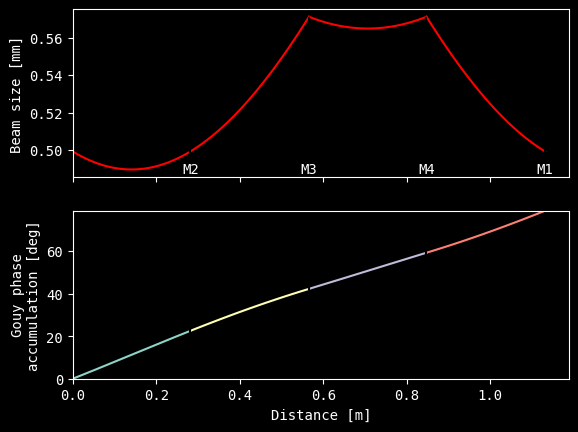

In [9]:
prop_trac.plot(); #Beam trace plot through the cavity from M1.p3.o to M1.p4.i. 

In [10]:
prop_trac.table()

,z,w0,zr,w,RoC,Acc. Gouy,q
M1.p3.o,0 m,489.63 um,707.85 mm,499.22 um,-3.7007 m,0°,-0.141 + 0.708j
M2.p1.i,281.5 mm,489.63 um,707.85 mm,499.22 um,3.7007 m,22.492°,0.141 + 0.708j
M2.p2.o,281.5 mm,489.63 um,707.85 mm,499.22 um,3.7007 m,22.492°,0.141 + 0.708j
M3.p1.i,565.7 mm,489.63 um,707.85 mm,571.09 um,1.604 m,42.224°,0.425 + 0.708j
M3.p2.o,565.7 mm,564.82 um,941.94 mm,571.09 um,-6.4444 m,42.224°,-0.141 + 0.942j
M4.p1.i,847.2 mm,564.82 um,941.94 mm,571.09 um,6.4444 m,59.221°,0.141 + 0.942j
M4.p2.o,847.2 mm,489.63 um,707.85 mm,571.09 um,-1.604 m,59.221°,-0.425 + 0.708j
M1.p4.i,1.1314 m,489.63 um,707.85 mm,499.22 um,-3.7007 m,78.953°,-0.141 + 0.708j


In [11]:
print("Cavity Beam Param: ",omc.OMC.source.q)
print("Cavity Round-Trip Gouy Phase (x): ",omc.OMC.gouy[0])

Cavity Beam Param:  (❮BeamParam (w0=489.63 um, w=499.22 um, z=-140.75 mm, nr=1, λ=1.064 um) at 0x7495b290aaa0❯, ❮BeamParam (w0=490.5 um, w=500.04 um, z=-140.75 mm, nr=1, λ=1.064 um) at 0x74962c452ec0❯)
Cavity Round-Trip Gouy Phase (x):  78.95301305450052


# Analysis <a class="anchor" id="third-bullet"></a>

The first thing I'd like to observe is the transmission of HOMs and how it depends on cavity parameters. 

In [12]:
import scipy.constants as const

In [13]:
half_gouy = omc.OMC.gouy[0]/2
FSR = omc.OMC.FSR
TSM = omc.OMC.mode_separation[0]
finesse = omc.OMC.finesse

In [14]:
sol = omc.run(f"xaxis(Input.f, lin, -{omc.OMC.FSR}, {omc.OMC.FSR}, 6000)")
#sol.plot();

In [15]:
xaxis = np.linspace(-1,1,6001) #xaxis definition

FinesseException: 	(use finesse.tb() to see the full traceback)
Could not find an output `Fundamental_trans` in the solution object ❮ArraySolution of xaxis @ 0x7495b03134c0 children=0❯

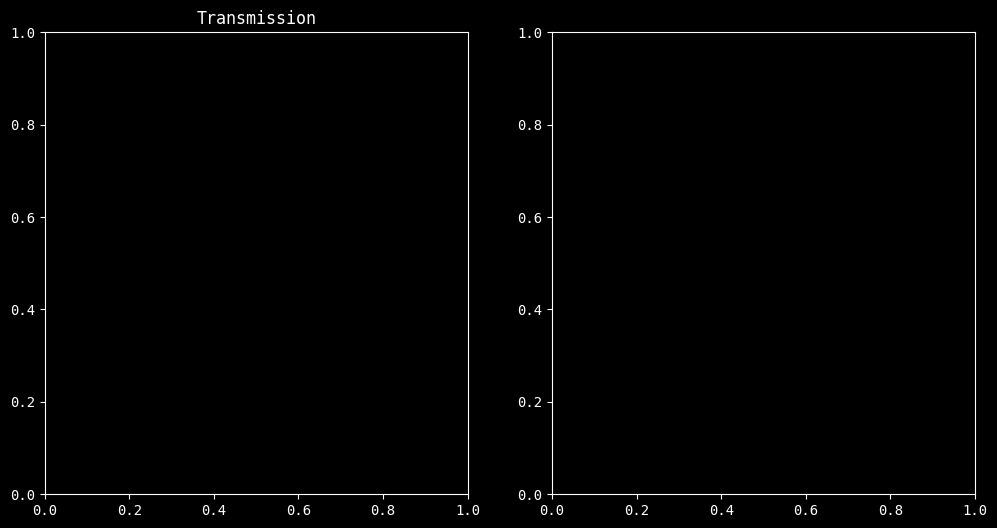

In [16]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))

#plt.axvline(TMS/FSR,0.05,1,label=f"TMS = {np.round(TSM/1e6,3)} [MHz]",color='grey',linestyle='dashed')
axs[0].set_title("Transmission")
axs[0].plot(xaxis,np.abs(sol["Fundamental_trans"]),label='Carrier')
axs[0].plot(xaxis,np.abs(sol["OneZero_trans"]),label='[1,0]')
axs[0].plot(xaxis,np.abs(sol["OneOne_trans"]),label='[1,1]')

axs[1].set_title("Reflection")
axs[1].plot(xaxis,np.abs(sol["Fundamental_refl"]),label='Carrier')
axs[1].plot(xaxis,np.abs(sol["OneZero_refl"]),label='[1,0]')
axs[1].plot(xaxis,np.abs(sol["OneOne_refl"]),label='[1,1]')
#plt.plot(xaxis,abs(sol["ZeroOne"])**2,label='[0,1]')
#plt.plot(xaxis,abs(sol["TwoZero"])**2,label='[2,0]')
#plt.plot(xaxis,abs(sol["ZeroTwo"])**2,label='[0,2]')

fig.supylabel(r'Amplitude [$\sqrt{W}$]',fontsize=14)
fig.supxlabel('Frequency Offset [FSR]',fontsize=14)
fig.suptitle('Laser Freq. Sweep',fontsize=18)
axs[0].legend(fontsize=10)

In [17]:
linear_omc.Mirror_RoC.ref

❮Symbolic='Mirror_RoC' @ 0x7495b031bc70❯

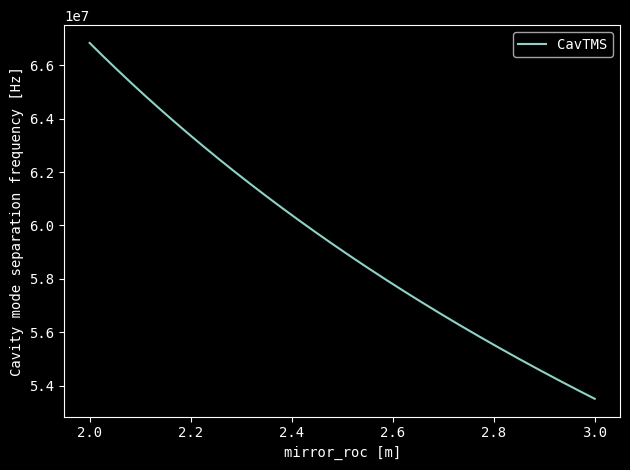

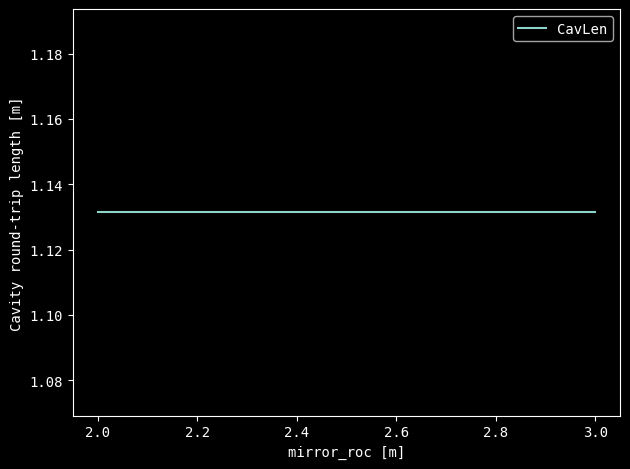

In [18]:
sol_lintestx2 = omc.run(fa.actions.Xaxis(roc,"lin",2.0,3.0,500))
sol_lintestx2.plot();

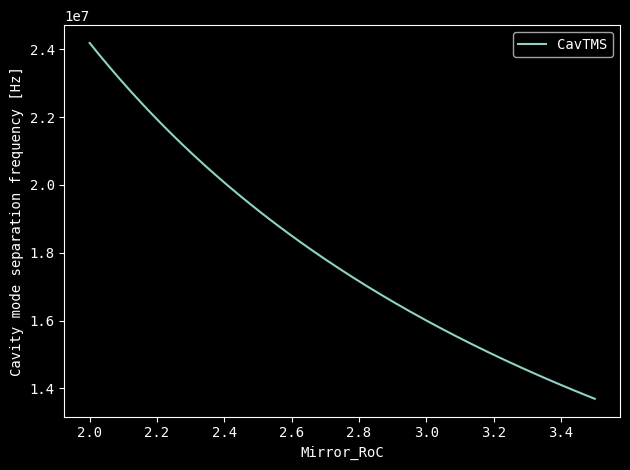

In [ ]:
sol_lintest1 = linear_omc.run("xaxis(Mirror_RoC,lin,2.0,3.5,5000)")
sol_lintest1.plot();

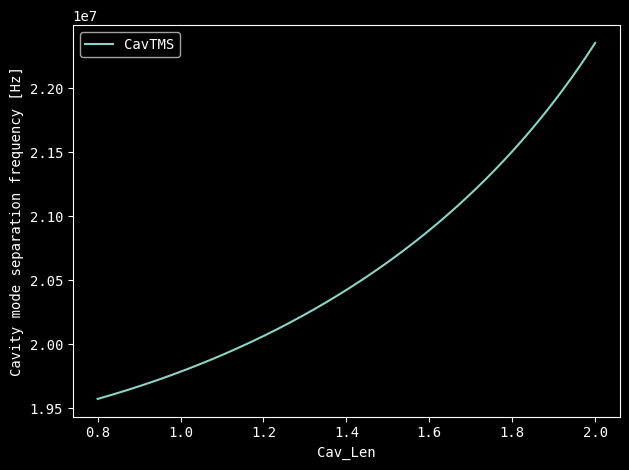

In [ ]:
sol_lintest2 = linear_omc.run("xaxis(Cav_Len,lin,0.8,2.0,5000)")
sol_lintest2.plot();